In [1]:
%matplotlib inline
import plot
import market
import metrics
from decimal import Decimal

In [2]:
m = market.Returns_US_1871()
years = 30
start_year = 1871
last_year = 2015-years

def run(stock_pct):
    swrs = {}
    for _ in range(last_year - start_year + 1):
        returns = []
#        if start_year + _ in (1965,1966,1967,1968,1969,1970,1971,1972,1973): continue
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swrs[start_year + _] = float(metrics.ssr(returns))
    return swrs

mswr = run(Decimal(.6))

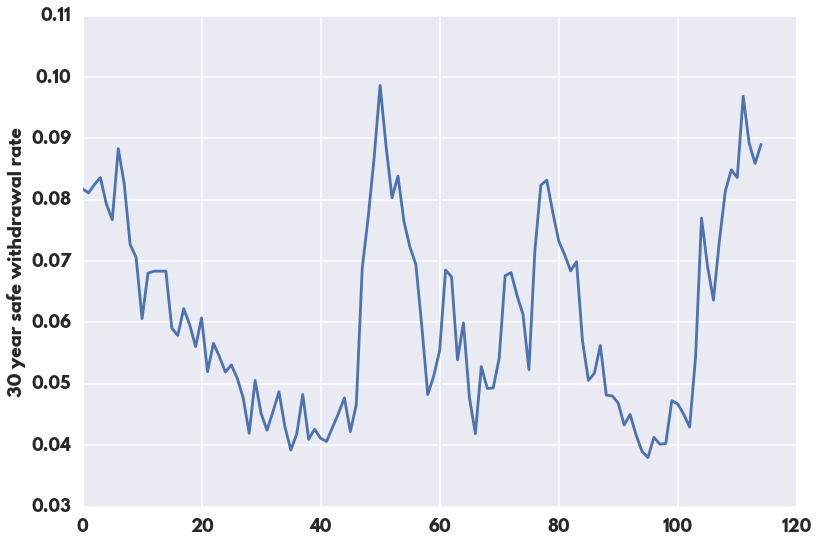

In [3]:
plot.plot([mswr[i] for i in mswr], y_label='30 year safe withdrawal rate', add_commas=False)

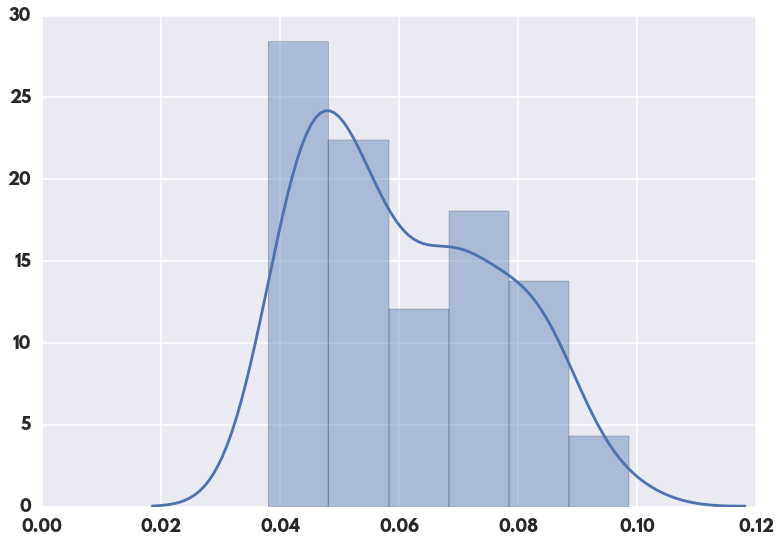

In [4]:
plot.seaborn.distplot([mswr[i] for i in mswr])

In [5]:
import pandas
import scipy.stats
pds = pandas.Series([mswr[i] for i in mswr])

scipy.stats.percentileofscore(pds, .05)
pds.quantile(.05)

0.040859448710844022

In [6]:
under45 = {k:v for k,v in mswr.items() if v <.045 }
s = pandas.Series()
for k,v in under45.items():
    s.loc[k] = v
print(s.head())
#s.to_csv('under45.csv')

1969    0.040295
1966    0.037990
1937    0.041872
1962    0.043298
1899    0.041958
dtype: float64


In [13]:
import metrics

def get_inflation(year, length=15):
    a = list(zip(range(length), m.iter_from(year)))
    inflations = [x[1].inflation for x in a]
    return metrics.average(inflations)

inflation = {}
for _ in range(last_year - start_year + 1):
    year = start_year + _
    inflation[year] = get_inflation(year)

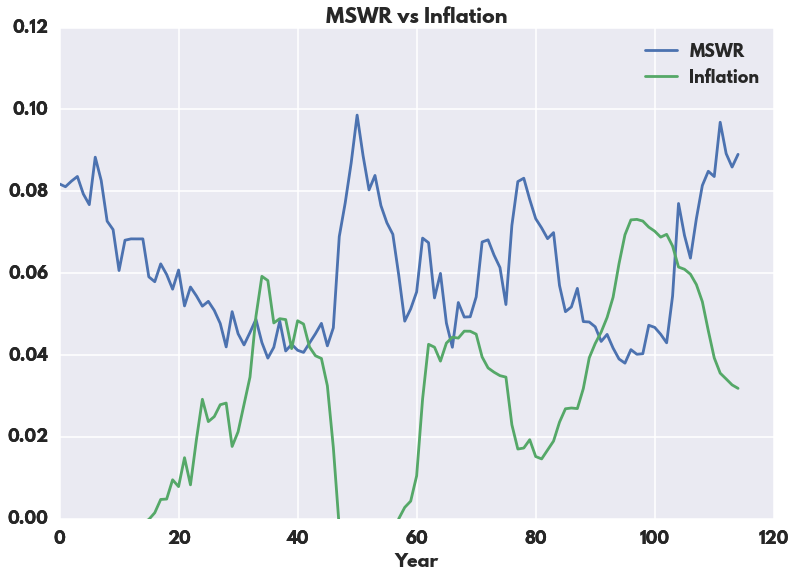

In [8]:
plot.plot_n({'MSWR' : [mswr[i] for i in sorted(mswr.keys())], 'Inflation' : [inflation[i] for i in sorted(inflation.keys())]},
           xlabel='Year', title='MSWR vs Inflation', add_commas=False)

In [9]:
cor_frame = pandas.DataFrame({'MSWR' : [mswr[i] for i in sorted(mswr.keys())], 'Inflation' : [inflation[i] for i in sorted(inflation.keys())]})
from statsmodels.formula.api import ols
model = ols("MSWR ~ Inflation", cor_frame).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSWR   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     57.50
Date:                Tue, 06 Dec 2016   Prob (F-statistic):           1.02e-11
Time:                        12:06:53   Log-Likelihood:                 337.79
No. Observations:                 115   AIC:                            -671.6
Df Residuals:                     113   BIC:                            -666.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0687      0.002     42.852      0.0

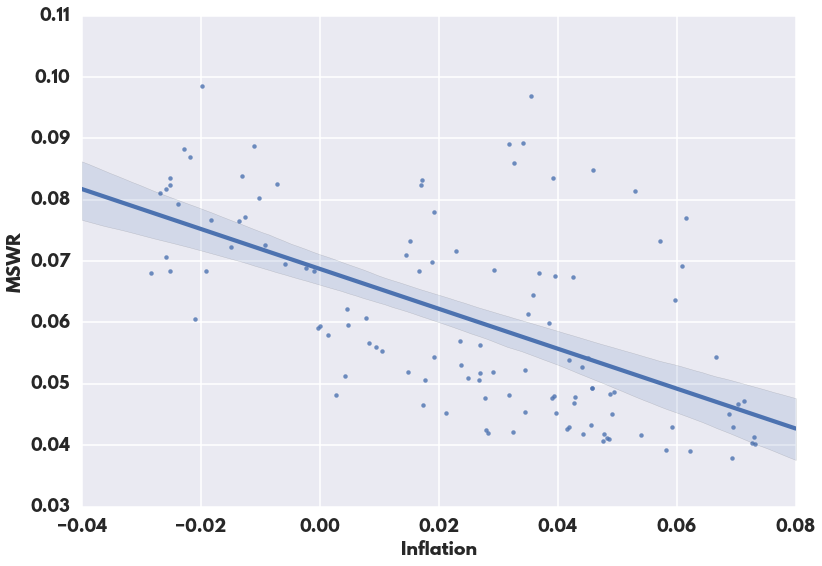

In [10]:
plot.seaborn.regplot(x='Inflation', y='MSWR', data=cor_frame)

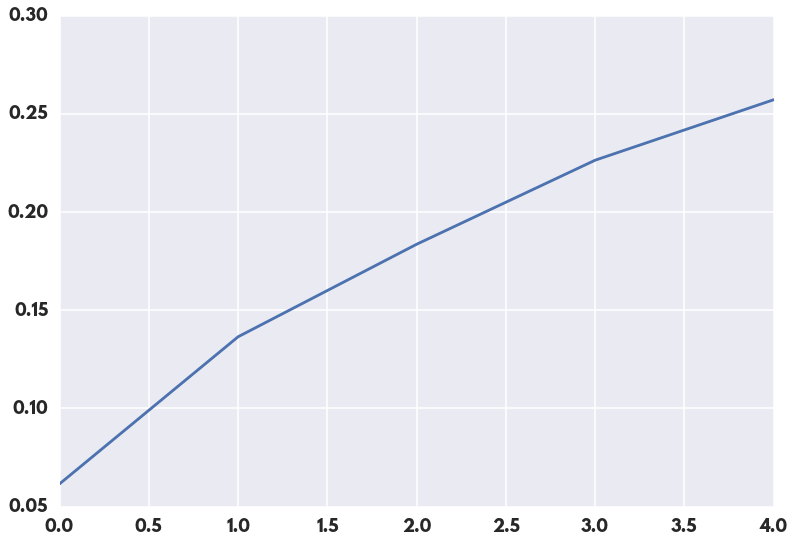

In [15]:
from statsmodels.formula.api import ols

def get_stocks(year, length=5):
    a = list(zip(range(length), m.iter_from(year)))
    stocks = [float(x[1].stocks) for x in a]
    return scipy.stats.gmean([x+1 for x in stocks]) - 1

def make_model(length):
    stocks = {}
    for _ in range(last_year - start_year + 1):
        year = start_year + _
        stocks[year] = get_stocks(year, length=length)
    cor_frame = pandas.DataFrame({'MSWR' : [mswr[i] for i in sorted(mswr.keys())], 'EquityReturns' : [stocks[i] for i in sorted(stocks.keys())]})
    model = ols("MSWR ~ EquityReturns", cor_frame).fit()
    return model

equity_check = pandas.Series()

for i in range(5):
    equity_check.loc[i] = make_model(i+1).rsquared

plot.seaborn.tsplot(equity_check)
#plot.seaborn.regplot(x='EquityReturns', y='MSWR', data=cor_frame)

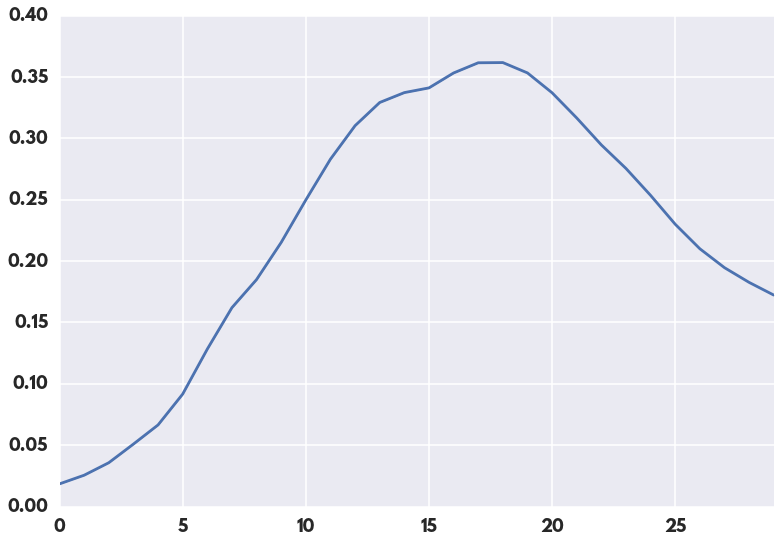

In [14]:
from statsmodels.formula.api import ols

def make_model(length):
    stocks = {}
    for _ in range(last_year - start_year + 1):
        year = start_year + _
        stocks[year] = get_inflation(year, length=length)
    cor_frame = pandas.DataFrame({'MSWR' : [mswr[i] for i in sorted(mswr.keys())], 'EquityReturns' : [stocks[i] for i in sorted(stocks.keys())]})
    model = ols("MSWR ~ EquityReturns", cor_frame).fit()
    return model

equity_check = pandas.Series()

for i in range(30):
    equity_check.loc[i] = make_model(i+1).rsquared

plot.seaborn.tsplot(equity_check)
#plot.seaborn.regplot(x='EquityReturns', y='MSWR', data=cor_frame)

0     0.084207
1     0.115224
2     0.148726
3     0.184766
4     0.215554
5     0.262261
6     0.332126
7     0.388242
8     0.423078
9     0.460078
10    0.504777
11    0.537936
12    0.558083
13    0.567775
14    0.555574
15    0.539085
16    0.533187
17    0.518893
18    0.496717
19    0.461980
20    0.419077
21    0.375883
22    0.335113
23    0.293102
24    0.249506
25    0.211277
26    0.178852
27    0.155060
28    0.136280
29    0.119339
dtype: float64


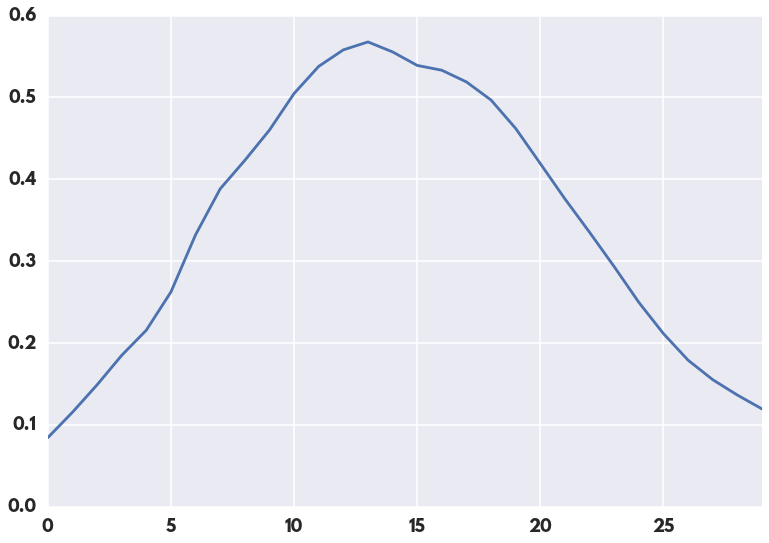

In [19]:
from statsmodels.formula.api import ols

def get_stocks(year, length=5):
    a = list(zip(range(length), m.iter_from(year)))
    stocks = [float(x[1].bonds) - float(x[1].inflation) for x in a]
    return scipy.stats.gmean([x+1 for x in stocks]) - 1

def make_model(length):
    stocks = {}
    for _ in range(last_year - start_year + 1):
        year = start_year + _
        stocks[year] = get_stocks(year, length=length)
    cor_frame = pandas.DataFrame({'MSWR' : [mswr[i] for i in sorted(mswr.keys())], 'EquityReturns' : [stocks[i] for i in sorted(stocks.keys())]})
    model = ols("MSWR ~ EquityReturns", cor_frame).fit()
    return model

equity_check = pandas.Series()

for i in range(30):
    equity_check.loc[i] = make_model(i+1).rsquared

print(equity_check)
plot.seaborn.tsplot(equity_check)
#plot.seaborn.regplot(x='EquityReturns', y='MSWR', data=cor_frame)